# Cutoff search

In [1]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
token = user_secrets.get_secret("token")

!git clone https://{token}@github.com/Benedart/RecSys-2022-Challenge-Polimi.git
    
import os

os.chdir( "./RecSys-2022-Challenge-Polimi")
!python run_compile_all_cython.py

Cloning into 'RecSys-2022-Challenge-Polimi'...
remote: Enumerating objects: 643, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 643 (delta 14), reused 21 (delta 8), pack-reused 615
Receiving objects: 100% (643/643), 1.06 GiB | 75.90 MiB/s, done.
Resolving deltas: 100% (280/280), done.
Updating files: 100% (205/205), done.
run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from MatrixFactorizationImpre

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.sparse as sps
import csv
import xgboost as xgb

from Recommenders.Recommender_import_list import *

#### Importing URM & ICM

In [3]:
URM_all = pd.read_csv("/kaggle/input/recommender-system-2022-challenge-polimi/interactions_and_impressions.csv")
ICM_type = pd.read_csv("/kaggle/input/recommender-system-2022-challenge-polimi/data_ICM_type.csv")
ICM_length = pd.read_csv("/kaggle/input/recommender-system-2022-challenge-polimi/data_ICM_length.csv")

ICM_all = pd.concat([ICM_type, ICM_length]).sort_values(by='item_id')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
URM_all

,UserID,ItemID,Impressions,Data
0,0,11,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19",1
1,0,21,NaN,0
2,0,21,NaN,0
3,0,21,"20,21,22,23,24,25,26,27,28,29",0
4,0,21,NaN,1
...,...,...,...,...
5826501,41628,20448,NaN,0
5826502,41628,20896,NaN,1
5826503,41628,21506,NaN,1
5826504,41628,22882,NaN,0


In [5]:
ICM_all

,item_id,feature_id,data
0,0,1,1
0,0,0,1
1,1,0,1
1,1,3,1
2,2,4,1
...,...,...,...
23088,27965,1,1
23089,27966,0,1
23089,27966,1,1
23090,27967,4,1


#### Getting rid of duplicates and empty indices
Let's start with the indices, the mapping is done for consistency

In [6]:
mapped_id, original_id = pd.factorize(URM_all["UserID"].unique())
user_original_Id_to_index = pd.Series(mapped_id, index=original_id)

print("Unique UserID in the URM are {}".format(len(original_id)))

mapped_id, original_id = pd.factorize(URM_all["ItemID"].unique())

print("Unique ItemID in the URM are {}".format(len(original_id)))

all_item_indices = pd.concat([URM_all["ItemID"], ICM_all["item_id"]], ignore_index=True)
mapped_id, original_id = pd.factorize(all_item_indices.unique())

print("Unique ItemID in the URM and ICM are {}".format(len(original_id)))

item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(ICM_all["feature_id"].unique())
feature_original_ID_to_index = pd.Series(mapped_id, index=original_id)

print("Unique FeatureID in the URM are {}".format(len(feature_original_ID_to_index)))

URM_all["UserID"] = URM_all["UserID"].map(user_original_Id_to_index)
URM_all["ItemID"] = URM_all["ItemID"].map(item_original_ID_to_index)
ICM_all["item_id"] = ICM_all["item_id"].map(item_original_ID_to_index)
ICM_all["feature_id"] = ICM_all["feature_id"].map(feature_original_ID_to_index)

Unique UserID in the URM are 41629
Unique ItemID in the URM are 24507
Unique ItemID in the URM and ICM are 27968
Unique FeatureID in the URM are 6


And then we remove duplicate values

In [7]:
URM_all = URM_all.drop(["Impressions", "Data"], axis=1).drop_duplicates()
URM_all["Rating"] = 1

In [8]:
URM_all

,UserID,ItemID,Rating
0,0,0,1
1,0,1,1
13,0,2,1
28,0,3,1
29,0,4,1
...,...,...,...
5826501,41628,3700,1
5826502,41628,12694,1
5826503,41628,15132,1
5826504,41628,18128,1


In [9]:
ICM_all

,item_id,feature_id,data
0,3668,0,1
0,3668,1,1
1,1945,1,1
1,1945,2,1
2,18373,3,1
...,...,...,...
23088,27965,0,1
23089,27966,1,1
23089,27966,0,1
23090,27967,3,1


#### Creating the matrices

In [10]:
n_users = len(user_original_Id_to_index)
n_items = len(item_original_ID_to_index)
n_features = len(feature_original_ID_to_index)

from sklearn.model_selection import train_test_split

seed = 42

(user_ids_training_validation, user_ids_test,
 item_ids_training_validation, item_ids_test,
 ratings_training_validation, ratings_test) = train_test_split(URM_all.UserID,
                                                    URM_all.ItemID,
                                                    URM_all.Rating,
                                                    test_size=0.15,
                                                    shuffle=True,
                                                    random_state=seed)

(user_ids_training, user_ids_validation,
 item_ids_training, item_ids_validation,
 ratings_training, ratings_validation) = train_test_split(user_ids_training_validation,
                                                          item_ids_training_validation,
                                                          ratings_training_validation,
                                                          test_size=0.15,
                                                          shuffle=True,
                                                          random_state=seed)


URM_all = sps.csr_matrix((URM_all.Rating, (URM_all.UserID, URM_all.ItemID)),
                           shape = (n_users, n_items))

URM_train = sps.csr_matrix((ratings_training, (user_ids_training, item_ids_training)),
                           shape = (n_users, n_items))

URM_validation = sps.csr_matrix((ratings_validation, (user_ids_validation, item_ids_validation)),
                           shape = (n_users, n_items))

URM_train_validation = sps.csr_matrix((ratings_training_validation, (user_ids_training_validation, item_ids_training_validation)),
                           shape = (n_users, n_items))

URM_test = sps.csr_matrix((ratings_test, (user_ids_test, item_ids_test)),
                           shape = (n_users, n_items))


ICM_all = sps.csr_matrix((np.ones(len(ICM_all["item_id"].values)), 
                          (ICM_all["item_id"].values, ICM_all["feature_id"].values)),
                        shape = (n_items, n_features))

ICM_all.data = np.ones_like(ICM_all.data)

ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

### Setting up evaluators

In [11]:
from Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 1520 ( 3.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 976 ( 2.3%) Users that have less than 1 test interactions


## Parameters!

In [12]:
params_elastic = {
    "topK": 6468,
    "l1_ratio": 0.03534306561986866,
    "alpha": 0.001,
}

params_rp3b = {
    "topK": 63,
    "alpha": 0.6871585126786798,
    "beta": 0.2893401754537936,
    "normalize_similarity": True
}
   
params_userKnn = {
    'topK': 570,
    'shrink': 197,
    'similarity': 'asymmetric',
    'asymmetric_alpha': 0.5016128296674885,
    'normalize': True,
    'feature_weighting': 'BM25',
    'URM_bias': 71.84496171909362
}

params_itemKnn = {
    'ICM_weight': 0.7942705620438129,
    'topK': 57,
    'shrink': 46,
    'similarity': 'asymmetric',
    'asymmetric_alpha': 1.0078079911435072,
    'normalize': True,
    'feature_weighting': 'BM25',
    'ICM_bias': 0.05378471200597431
}

params_IALS = {
    'epochs': 34,
    'num_factors': 79,
    'alpha': 5.743821416717141,
    'epsilon': 0.3498236011181738,
    'reg': 0.13292125016403122
}

params_p3a = {'topK': 114, 'alpha': 1.0704657899898833, 'normalize_similarity': True}

### Creating the hybrid recommender

In [13]:
SLIM_Elastic_train = SLIMElasticNetRecommender(URM_train)
# SLIM_Elastic.fit(**params_elastic)

SLIM_Elastic_train.load_model('models', 'SLIM_Elastic_train.zip')

SLIMElasticNetRecommender: URM Detected 3461 (12.4%) items with no interactions.
SLIMElasticNetRecommender: Loading model from file 'modelsSLIM_Elastic_train.zip'
SLIMElasticNetRecommender: Loading complete


In [14]:
SLIM_Elastic_train_validation = SLIMElasticNetRecommender(URM_train_validation)
# SLIM_Elastic_train_validation.fit(**params_elastic)

SLIM_Elastic_train_validation.load_model('models', 'SLIM_Elastic_train_validation.zip')

SLIMElasticNetRecommender: URM Detected 3461 (12.4%) items with no interactions.
SLIMElasticNetRecommender: Loading model from file 'modelsSLIM_Elastic_train_validation.zip'
SLIMElasticNetRecommender: Loading complete


In [15]:
RP3Beta_train = RP3betaRecommender(URM_train)
RP3Beta_train.fit(**params_rp3b)

RP3betaRecommender: URM Detected 3461 (12.4%) items with no interactions.
RP3betaRecommender: Similarity column 27968 (100.0%), 3125.13 column/sec. Elapsed time 8.95 sec


In [16]:
RP3Beta_train_validation = RP3betaRecommender(URM_train_validation)
RP3Beta_train_validation .fit(**params_rp3b)

RP3betaRecommender: URM Detected 3461 (12.4%) items with no interactions.
RP3betaRecommender: Similarity column 27968 (100.0%), 2877.71 column/sec. Elapsed time 9.72 sec


In [17]:
IALS_train_validation = IALSRecommender(URM_train_validation)
# IALS_train_validation.fit(**params_IALS)
IALS_train_validation.load_model("models", "IALS_train_validation.zip")

IALSRecommender: URM Detected 3461 (12.4%) items with no interactions.
IALSRecommender: Loading model from file 'modelsIALS_train_validation.zip'
IALSRecommender: Loading complete


In [18]:
IALS_train = IALSRecommender(URM_train)
# IALS_train.fit(**params_IALS)
IALS_train.load_model("models", "IALS_train.zip")

IALSRecommender: URM Detected 3461 (12.4%) items with no interactions.
IALSRecommender: Loading model from file 'modelsIALS_train.zip'
IALSRecommender: Loading complete


In [19]:
UserKNN_train = UserKNNCFRecommender(URM_train)
UserKNN_train.fit(**params_userKnn)

UserKNNCFRecommender: URM Detected 3461 (12.4%) items with no interactions.
Similarity column 41629 (100.0%), 2058.70 column/sec. Elapsed time 20.22 sec


In [20]:
UserKNN_train_validation = UserKNNCFRecommender(URM_train_validation)
UserKNN_train_validation.fit(**params_userKnn)

UserKNNCFRecommender: URM Detected 3461 (12.4%) items with no interactions.
Similarity column 41629 (100.0%), 1829.25 column/sec. Elapsed time 22.76 sec


In [21]:
ItemKNN_CFCBF_train = ItemKNN_CFCBF_Hybrid_Recommender(URM_train, ICM_all)
ItemKNN_CFCBF_train.fit(**params_itemKnn)

ItemKNN_CFCBF_HybridRecommender: URM Detected 3461 (12.4%) items with no interactions.
ItemKNN_CFCBF_HybridRecommender: ICM Detected 4877 (17.4%) items with no features.
Similarity column 27968 (100.0%), 1504.46 column/sec. Elapsed time 18.59 sec


In [22]:
ItemKNN_CFCBF_train_validation = ItemKNN_CFCBF_Hybrid_Recommender(URM_train_validation, ICM_all)
ItemKNN_CFCBF_train_validation.fit(**params_itemKnn)

ItemKNN_CFCBF_HybridRecommender: URM Detected 3461 (12.4%) items with no interactions.
ItemKNN_CFCBF_HybridRecommender: ICM Detected 4877 (17.4%) items with no features.
Similarity column 27968 (100.0%), 1470.23 column/sec. Elapsed time 19.02 sec


In [23]:
P3Alpha_train = P3alphaRecommender(URM_train)
P3Alpha_train.fit(**params_p3a)

P3alphaRecommender: URM Detected 3461 (12.4%) items with no interactions.
P3alphaRecommender: Similarity column 27968 (100.0%), 3111.37 column/sec. Elapsed time 8.99 sec


In [24]:
P3Alpha_train_validation = P3alphaRecommender(URM_train_validation)
P3Alpha_train_validation.fit(**params_p3a)

P3alphaRecommender: URM Detected 3461 (12.4%) items with no interactions.
P3alphaRecommender: Similarity column 27968 (100.0%), 2795.94 column/sec. Elapsed time 10.00 sec


In [25]:
recommenders_train = [SLIM_Elastic_train, RP3Beta_train, IALS_train] 
alphas = [
    2.097339118738173, 
    1.0568674680305168,
    0.1617624215703209
]

recommender_train = GeneralizedLinearHybridRecommender(
    URM_train = URM_train, 
    recommenders=recommenders_train
)

recommender_train.fit(alphas)

SLIMElasticNetRP3betaIALSHybridRecommender: URM Detected 3461 (12.4%) items with no interactions.


In [26]:
recommenders_train_validation = [SLIM_Elastic_train_validation, RP3Beta_train_validation, IALS_train_validation] 
recommender_train_validation = GeneralizedLinearHybridRecommender(
    URM_train = URM_train_validation, 
    recommenders=recommenders_train_validation
)

recommender_train_validation.fit(alphas)

SLIMElasticNetRP3betaIALSHybridRecommender: URM Detected 3461 (12.4%) items with no interactions.


In [27]:
evaluator_test.evaluateRecommender(recommender_train_validation)

EvaluatorHoldout: Processed 40653 (100.0%) in 53.34 sec. Users per second: 762


(       PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                      
 10      0.056392                  0.09428  0.088091  0.028082    0.045807   
 
              MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                        ...   
 10      0.185461  0.090701  0.068764  0.367009      0.226533  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.976555          0.358404    0.976555        0.02071   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10             9.18221                   0.995157             0.046466   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                   

In [28]:
!cp -r /kaggle/input/ease-r/* models/

os.chdir("models")
! for i in */; do (cd "$i"; zip -r "../${i%/}.zip" .); done
! rm -R -- */
os.chdir("..")

  adding: W_sparse.npy (deflated 30%)
  adding: W_sparse.npy (deflated 30%)
  adding: W_sparse.npy (deflated 30%)


In [29]:
EASE_R_train = EASE_R_Recommender(URM_train)
EASE_R_train.load_model("models", "EASE_R_train.zip")

EASE_R_Recommender: URM Detected 3461 (12.4%) items with no interactions.
EASE_R_Recommender: Loading model from file 'modelsEASE_R_train.zip'
EASE_R_Recommender: Loading complete


In [30]:
EASE_R_train_validation = EASE_R_Recommender(URM_train_validation)
EASE_R_train_validation.load_model("models", "EASE_R_train_validation.zip")

EASE_R_Recommender: URM Detected 3461 (12.4%) items with no interactions.
EASE_R_Recommender: Loading model from file 'modelsEASE_R_train_validation.zip'
EASE_R_Recommender: Loading complete


## Let's build the training dataframe

In [31]:
import pandas as pd
from tqdm import tqdm
import scipy.sparse as sps
import numpy as np

In [32]:
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

candidate_generator_recommender = recommender_train

In [33]:
cutoff = 35

for user_id in tqdm(range(n_users)):    
    recommendations = candidate_generator_recommender.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations

training_dataframe = training_dataframe.explode("ItemID")

100%|██████████| 41629/41629 [02:17<00:00, 301.98it/s]


In [34]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,0
1,0,16
2,0,57
3,1,67
4,2,94
...,...,...
198212,41627,7185
198213,41627,8875
198214,41627,11300
198215,41627,19379


In [35]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe

,UserID,ItemID,Exist
0,0,175,left_only
1,0,108,left_only
2,0,1966,left_only
3,0,111,left_only
4,0,1178,left_only
...,...,...,...
1457010,41628,1221,left_only
1457011,41628,9975,left_only
1457012,41628,12124,left_only
1457013,41628,1968,left_only


In [36]:
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,175,False
1,0,108,False
2,0,1966,False
3,0,111,False
4,0,1178,False
...,...,...,...
1457010,41628,1221,False
1457011,41628,9975,False
1457012,41628,12124,False
1457013,41628,1968,False


#### Now let's add some features. For example, the prediction of another algorithm

In [37]:
other_algorithms = {
    "Hybrid": recommender_train,
    "SLIM_Elastic": SLIM_Elastic_train,
    "RP3Beta": RP3Beta_train,
    "ItemKNN_CFCBF": ItemKNN_CFCBF_train,
    "UserKNN": UserKNN_train,
    "IALS": IALS_train,
    "EASE_R": EASE_R_train,
    "P3Alpha": P3Alpha_train,
}

In [38]:
training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm(range(n_users)):       
    for rec_label, rec_instance in other_algorithms.items():
        
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

100%|██████████| 41629/41629 [18:22<00:00, 37.74it/s]


,UserID,ItemID,Label,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,EASE_R,P3Alpha
0,0,175,False,0.637200,0.213291,0.076454,0.272315,4.829669,0.674174,0.068043,0.060122
1,0,108,False,0.623065,0.230603,0.077193,0.397807,4.030036,0.357495,0.082289,0.048343
2,0,1966,False,0.607503,0.192092,0.118657,0.754518,9.551718,0.489712,0.100417,0.077548
3,0,111,False,0.579461,0.219165,0.074563,0.340281,1.654330,0.253423,0.084469,0.045536
4,0,1178,False,0.568901,0.142871,0.144922,0.843939,8.525221,0.717660,0.085792,0.121668
...,...,...,...,...,...,...,...,...,...,...,...
1457010,41628,1221,False,0.086993,0.043967,0.000000,0.000000,0.977427,-0.032268,0.001802,0.026931
1457011,41628,9975,False,0.086517,0.025883,0.013525,0.057763,0.921853,0.110899,0.008434,0.000000
1457012,41628,12124,False,0.085030,0.027006,0.027535,0.100778,0.000000,-0.004406,0.003818,0.011478
1457013,41628,1968,False,0.084542,0.025014,0.022360,0.088530,1.314531,0.052217,0.002762,0.017896


#### Or the profile length

In [39]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)

training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,EASE_R,P3Alpha,item_popularity
0,0,175,False,0.637200,0.213291,0.076454,0.272315,4.829669,0.674174,0.068043,0.060122,957
1,0,108,False,0.623065,0.230603,0.077193,0.397807,4.030036,0.357495,0.082289,0.048343,477
2,0,1966,False,0.607503,0.192092,0.118657,0.754518,9.551718,0.489712,0.100417,0.077548,344
3,0,111,False,0.579461,0.219165,0.074563,0.340281,1.654330,0.253423,0.084469,0.045536,469
4,0,1178,False,0.568901,0.142871,0.144922,0.843939,8.525221,0.717660,0.085792,0.121668,651
...,...,...,...,...,...,...,...,...,...,...,...,...
1457010,41628,1221,False,0.086993,0.043967,0.000000,0.000000,0.977427,-0.032268,0.001802,0.026931,2073
1457011,41628,9975,False,0.086517,0.025883,0.013525,0.057763,0.921853,0.110899,0.008434,0.000000,106
1457012,41628,12124,False,0.085030,0.027006,0.027535,0.100778,0.000000,-0.004406,0.003818,0.011478,34
1457013,41628,1968,False,0.084542,0.025014,0.022360,0.088530,1.314531,0.052217,0.002762,0.017896,284


In [40]:
user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)

training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,EASE_R,P3Alpha,item_popularity,user_profile_len
0,0,175,False,0.637200,0.213291,0.076454,0.272315,4.829669,0.674174,0.068043,0.060122,957,51
1,0,108,False,0.623065,0.230603,0.077193,0.397807,4.030036,0.357495,0.082289,0.048343,477,51
2,0,1966,False,0.607503,0.192092,0.118657,0.754518,9.551718,0.489712,0.100417,0.077548,344,51
3,0,111,False,0.579461,0.219165,0.074563,0.340281,1.654330,0.253423,0.084469,0.045536,469,51
4,0,1178,False,0.568901,0.142871,0.144922,0.843939,8.525221,0.717660,0.085792,0.121668,651,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457010,41628,1221,False,0.086993,0.043967,0.000000,0.000000,0.977427,-0.032268,0.001802,0.026931,2073,22
1457011,41628,9975,False,0.086517,0.025883,0.013525,0.057763,0.921853,0.110899,0.008434,0.000000,106,22
1457012,41628,12124,False,0.085030,0.027006,0.027535,0.100778,0.000000,-0.004406,0.003818,0.011478,34,22
1457013,41628,1968,False,0.084542,0.025014,0.022360,0.088530,1.314531,0.052217,0.002762,0.017896,284,22


### and also item features

In [41]:
ICM_type = ICM_type.drop(["data"], axis=1) # drop the data column on type
ICM_length = ICM_length.drop(["feature_id"], axis=1) # drop the featureId column on type

ICM = ICM_type.merge(ICM_length, on="item_id", how="left")
ICM.rename(columns={'data': 'item_length', "feature_id": "item_type"}, inplace=True)
ICM['item_id'] = ICM['item_id'].map(item_original_ID_to_index)
ICM

,item_id,item_type,item_length
0,3668,1,1
1,1945,3,1
2,18373,4,21
3,7153,1,1
4,3423,3,1
...,...,...,...
23086,27963,1,1
23087,27964,2,1
23088,27965,1,1
23089,27966,1,1


In [42]:
icm_length_mapped = ICM.drop(['item_type'], axis=1).rename(columns={'item_id': 'ItemID'})

In [43]:
features_df = pd.DataFrame.sparse.from_spmatrix(ICM_all)
features_df

,0,1,2,3,4,5
0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
27963,1.0,1.0,0.0,0.0,0.0,0.0
27964,0.0,1.0,0.0,0.0,1.0,0.0
27965,1.0,1.0,0.0,0.0,0.0,0.0
27966,1.0,1.0,0.0,0.0,0.0,0.0


In [44]:
training_dataframe = training_dataframe.set_index('ItemID').join(features_df, how='inner')
training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "ItemID"})
training_dataframe

,ItemID,UserID,Label,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,EASE_R,P3Alpha,item_popularity,user_profile_len,0,1,2,3,4,5
0,0,112,False,0.097501,0.035540,0.019316,0.087200,0.793073,0.015743,0.008242,0.006725,49,16,1.0,1.0,0.0,0.0,0.0,0.0
1,0,405,False,0.117105,0.040997,0.026410,0.104258,1.465823,0.019828,0.006732,0.008832,49,13,1.0,1.0,0.0,0.0,0.0,0.0
2,0,3025,False,0.117777,0.040997,0.026410,0.104258,0.786471,0.023985,0.007109,0.008832,49,14,1.0,1.0,0.0,0.0,0.0,0.0
3,0,3353,False,0.117471,0.040997,0.026410,0.104258,1.573662,0.022093,0.008747,0.008832,49,12,1.0,1.0,0.0,0.0,0.0,0.0
4,0,3809,False,0.266854,0.093142,0.045726,0.303551,4.286197,0.143281,0.021337,0.015558,49,45,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457010,24502,3985,False,0.040387,0.009078,0.020135,0.102144,2.037897,0.000419,0.001854,0.008113,17,7,1.0,1.0,0.0,0.0,0.0,0.0
1457011,24502,15571,False,0.040454,0.009078,0.020135,0.102144,1.916101,0.000837,0.001826,0.008113,17,8,1.0,1.0,0.0,0.0,0.0,0.0
1457012,24502,34787,False,0.057329,0.008591,0.037052,0.121255,3.461847,0.000946,0.001884,0.019352,17,8,1.0,1.0,0.0,0.0,0.0,0.0
1457013,24502,37735,False,0.057374,0.008591,0.037052,0.121255,2.983996,0.001221,0.001843,0.019352,17,11,1.0,1.0,0.0,0.0,0.0,0.0


In [45]:
training_dataframe = training_dataframe.merge(icm_length_mapped, how="left")
training_dataframe['item_length'] = training_dataframe['item_length'].fillna(0).astype(int)

In [46]:
training_dataframe = training_dataframe.sort_values("UserID").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)
training_dataframe

,ItemID,UserID,Label,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,EASE_R,P3Alpha,item_popularity,user_profile_len,0,1,2,3,4,5,item_length
0,460,0,False,0.286877,0.077699,0.059051,0.622798,8.776323,0.380233,0.061522,0.042665,222,51,0.0,1.0,0.0,1.0,0.0,0.0,17
1,110,0,False,0.438432,0.127914,0.091770,0.607081,14.727746,0.452292,0.102642,0.075461,693,51,0.0,1.0,1.0,0.0,0.0,0.0,1
2,1968,0,False,0.323903,0.094600,0.063413,0.474654,5.116649,0.361486,0.072076,0.037559,284,51,1.0,1.0,0.0,0.0,0.0,0.0,3
3,544,0,False,0.359063,0.118624,0.051796,0.610683,2.001427,0.343268,0.054764,0.048164,593,51,0.0,1.0,0.0,1.0,0.0,0.0,14
4,175,0,False,0.637200,0.213291,0.076454,0.272315,4.829669,0.674174,0.068043,0.060122,957,51,0.0,1.0,1.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457010,1968,41628,False,0.084542,0.025014,0.022360,0.088530,1.314531,0.052217,0.002762,0.017896,284,22,1.0,1.0,0.0,0.0,0.0,0.0,3
1457011,361,41628,False,0.096451,0.034568,0.023297,0.058420,2.188093,-0.004158,0.012986,0.000000,403,22,0.0,0.0,0.0,0.0,0.0,0.0,0
1457012,3872,41628,False,0.128649,0.028627,0.047878,0.178677,3.987469,0.111325,0.018532,0.021061,94,22,1.0,1.0,0.0,0.0,0.0,0.0,3
1457013,2956,41628,False,0.196146,0.043715,0.040220,0.206857,6.417034,0.382989,0.047883,0.015564,669,22,0.0,1.0,0.0,1.0,0.0,0.0,8


## Training the model

In [47]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([35, 35, 35, ..., 35, 35, 35])

In [48]:
from xgboost import XGBRanker

n_estimators = 1000
learning_rate = 0.19823429576094637
reg_alpha = 47
reg_lambda = 0.313
max_depth = 3
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

colsample_bytree = 0.6113704247857885
gamma = 8.964184693722684
min_child_weight = 7.0

# {'colsample_bytree': 0.6113704247857885, 'eta': 0.19823429576094637, 'gamma': 8.964184693722684, 'max_depth': 3.0, 'min_child_weight': 7.0, 'n_estimators': 999.4831125773494, 'reg_alpha': 47.0, 'reg_lambda': 0.31301033504263204}

XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      colsample_bytree = colsample_bytree,
                      gamma = gamma,
                      min_child_weight = min_child_weight,
                      tree_method = "hist",
             #         enable_categorical = True
                      )

X_train_xgb = training_dataframe.drop(columns=["Label"])
y_train = training_dataframe["Label"]

XGB_model.fit(X_train_xgb,
              y_train,
              group=groups,
              verbose=True)

XGBRanker(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.6113704247857885,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, gamma=8.964184693722684, gpu_id=-1,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints='', learning_rate=0.19823429576094637,
          max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=3,
          max_leaves=0, min_child_weight=7.0, missing=nan,
          monotone_constraints='()', n_estimators=1000, n_jobs=0,
          num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=47,
          reg_lambda=0.313, ...)

In [49]:
from lightgbm import LGBMRanker

X_train = training_dataframe.drop(columns=["Label"])
y_train = training_dataframe["Label"]

lgbm_groups = training_dataframe.groupby("UserID")["UserID"].count().to_numpy()

params = {
    'n_estimators': 100,
    'learning_rate': 0.13405181674054625,
    'num_leaves': 40,
    'max_depth': 23,
    'reg_alpha': 3.6925887571025783e-07,
    'reg_lambda': 9.579462582658655,
    'bagging_fraction': 0.1,
    'feature_fraction': 1.0
}

lgbm = LGBMRanker()
lgbm.fit(X_train, y_train, 
         group=lgbm_groups)

LGBMRanker()

In [50]:
%matplotlib inline
from xgboost import plot_importance

<AxesSubplot:title={'center':'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

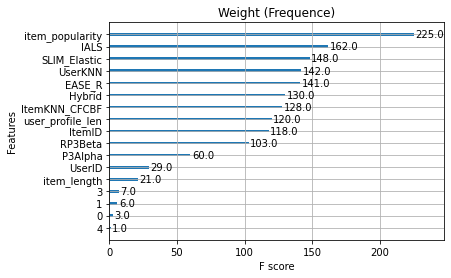

In [51]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

## Creating the dataframe with the predictions

In [52]:
users_to_recommend = np.unique(URM_test.tocoo().row)

user_recommendations_items = []
user_recommendations_user_id = []

for id in tqdm(users_to_recommend):
    # getting the recommendations
    recommendations = recommender_train_validation.recommend(user_id_array=id, remove_seen_flag=True, cutoff=cutoff)
    
    user_recommendations_items.extend(recommendations)
    user_recommendations_user_id.extend([id]*len(recommendations))
    
test_dataframe = pd.DataFrame({"UserID":user_recommendations_user_id, "ItemID":user_recommendations_items})
test_dataframe

100%|██████████| 40653/40653 [01:55<00:00, 351.56it/s]


,UserID,ItemID
0,0,108
1,0,111
2,0,175
3,0,2
4,0,1966
...,...,...
1422850,41627,187
1422851,41627,691
1422852,41627,4098
1422853,41627,962


#### Now let's add some features. For example, the prediction of another algorithm

In [53]:
other_algorithms_train_validation = {
    "Hybrid": recommender_train_validation,
    "SLIM_Elastic": SLIM_Elastic_train_validation,
    "RP3Beta": RP3Beta_train_validation,
    "ItemKNN_CFCBF": ItemKNN_CFCBF_train_validation,
    "UserKNN": UserKNN_train_validation,
    "IALS": IALS_train_validation,
    "EASE_R": EASE_R_train_validation,
    "P3Alpha": P3Alpha_train_validation,
}

In [54]:
test_dataframe = test_dataframe.set_index('UserID')

for user_id in tqdm(users_to_recommend):       
    for rec_label, rec_instance in other_algorithms_train_validation.items():
        
        item_list = test_dataframe.loc[user_id, "ItemID"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        test_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

test_dataframe = test_dataframe.reset_index()
test_dataframe = test_dataframe.rename(columns = {"index": "UserID"})
test_dataframe

100%|██████████| 40653/40653 [16:59<00:00, 39.89it/s]


,UserID,ItemID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,EASE_R,P3Alpha
0,0,108,0.697307,0.264059,0.077898,0.473369,3.740371,0.378070,0.100350,0.049158
1,0,111,0.691866,0.256940,0.076098,0.396982,1.446956,0.448495,0.105285,0.047010
2,0,175,0.667570,0.246935,0.074802,0.323145,4.486172,0.436492,0.082095,0.056642
3,0,2,0.658628,0.235880,0.116498,0.462028,6.746881,0.252120,0.221753,0.123025
4,0,1966,0.563180,0.194355,0.063808,0.852496,4.860466,0.544722,0.110673,0.063232
...,...,...,...,...,...,...,...,...,...,...
1422850,41627,187,0.343155,0.140698,0.036790,0.216681,18.802559,0.056764,0.126599,0.038927
1422851,41627,691,0.339567,0.085257,0.057829,0.596258,18.697144,0.615950,0.070109,0.037097
1422852,41627,4098,0.337127,0.080126,0.059767,0.468733,16.739471,0.654721,0.055771,0.035670
1422853,41627,962,0.332167,0.128219,0.021475,0.129487,23.651321,0.250692,0.097873,0.035195


#### Or the item popularity and profile length

In [55]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train_validation).indptr)

test_dataframe['item_popularity'] = item_popularity[test_dataframe["ItemID"].values.astype(int)]
test_dataframe

,UserID,ItemID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,EASE_R,P3Alpha,item_popularity
0,0,108,0.697307,0.264059,0.077898,0.473369,3.740371,0.378070,0.100350,0.049158,585
1,0,111,0.691866,0.256940,0.076098,0.396982,1.446956,0.448495,0.105285,0.047010,557
2,0,175,0.667570,0.246935,0.074802,0.323145,4.486172,0.436492,0.082095,0.056642,1144
3,0,2,0.658628,0.235880,0.116498,0.462028,6.746881,0.252120,0.221753,0.123025,5085
4,0,1966,0.563180,0.194355,0.063808,0.852496,4.860466,0.544722,0.110673,0.063232,409
...,...,...,...,...,...,...,...,...,...,...,...
1422850,41627,187,0.343155,0.140698,0.036790,0.216681,18.802559,0.056764,0.126599,0.038927,4663
1422851,41627,691,0.339567,0.085257,0.057829,0.596258,18.697144,0.615950,0.070109,0.037097,315
1422852,41627,4098,0.337127,0.080126,0.059767,0.468733,16.739471,0.654721,0.055771,0.035670,284
1422853,41627,962,0.332167,0.128219,0.021475,0.129487,23.651321,0.250692,0.097873,0.035195,984


In [56]:
user_popularity = np.ediff1d(sps.csr_matrix(URM_train_validation).indptr)

test_dataframe['user_profile_len'] = user_popularity[test_dataframe["UserID"].values.astype(int)]
test_dataframe

,UserID,ItemID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,EASE_R,P3Alpha,item_popularity,user_profile_len
0,0,108,0.697307,0.264059,0.077898,0.473369,3.740371,0.378070,0.100350,0.049158,585,54
1,0,111,0.691866,0.256940,0.076098,0.396982,1.446956,0.448495,0.105285,0.047010,557,54
2,0,175,0.667570,0.246935,0.074802,0.323145,4.486172,0.436492,0.082095,0.056642,1144,54
3,0,2,0.658628,0.235880,0.116498,0.462028,6.746881,0.252120,0.221753,0.123025,5085,54
4,0,1966,0.563180,0.194355,0.063808,0.852496,4.860466,0.544722,0.110673,0.063232,409,54
...,...,...,...,...,...,...,...,...,...,...,...,...
1422850,41627,187,0.343155,0.140698,0.036790,0.216681,18.802559,0.056764,0.126599,0.038927,4663,43
1422851,41627,691,0.339567,0.085257,0.057829,0.596258,18.697144,0.615950,0.070109,0.037097,315,43
1422852,41627,4098,0.337127,0.080126,0.059767,0.468733,16.739471,0.654721,0.055771,0.035670,284,43
1422853,41627,962,0.332167,0.128219,0.021475,0.129487,23.651321,0.250692,0.097873,0.035195,984,43


### and also item features

In [57]:
features_df = pd.DataFrame.sparse.from_spmatrix(ICM_all)
features_df

,0,1,2,3,4,5
0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
27963,1.0,1.0,0.0,0.0,0.0,0.0
27964,0.0,1.0,0.0,0.0,1.0,0.0
27965,1.0,1.0,0.0,0.0,0.0,0.0
27966,1.0,1.0,0.0,0.0,0.0,0.0


In [58]:
test_dataframe = test_dataframe.set_index('ItemID').join(features_df, how='inner')
test_dataframe = test_dataframe.reset_index()
test_dataframe = test_dataframe.rename(columns = {"index": "ItemID"})
test_dataframe

,ItemID,UserID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,EASE_R,P3Alpha,item_popularity,user_profile_len,0,1,2,3,4,5
0,0,112,0.100717,0.037681,0.018218,0.082851,0.000000,0.015034,0.007286,0.000000,59,18,1.0,1.0,0.0,0.0,0.0,0.0
1,0,405,0.138679,0.049029,0.028770,0.119949,0.794204,0.033645,0.009087,0.009890,59,14,1.0,1.0,0.0,0.0,0.0,0.0
2,0,3025,0.138937,0.049029,0.028770,0.119949,1.378823,0.035240,0.008231,0.009890,59,16,1.0,1.0,0.0,0.0,0.0,0.0
3,0,3353,0.135919,0.049029,0.028770,0.119949,0.789027,0.016581,0.009837,0.009890,59,15,1.0,1.0,0.0,0.0,0.0,0.0
4,0,4044,0.035521,0.007601,0.018426,0.057457,2.661645,0.000646,0.002530,0.011507,59,6,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422850,24458,41259,0.045582,0.020553,0.000000,0.053273,0.000000,0.015297,0.002563,0.000000,34,13,0.0,1.0,0.0,1.0,0.0,0.0
1422851,24475,31629,0.041937,0.008551,0.022624,0.104074,1.083884,0.000566,0.001829,0.009243,17,9,0.0,1.0,1.0,0.0,0.0,0.0
1422852,24501,15484,0.071553,0.033544,0.000000,0.078788,0.000000,0.007423,0.002706,0.000000,34,12,0.0,0.0,0.0,0.0,0.0,0.0
1422853,24501,37769,0.070925,0.033544,0.000000,0.078788,0.000000,0.003542,0.003194,0.000000,34,8,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
test_dataframe = test_dataframe.merge(icm_length_mapped, how="left")
test_dataframe['item_length'] = test_dataframe['item_length'].fillna(0).astype(int)

In [60]:
test_dataframe = test_dataframe.sort_values("UserID").reset_index()
test_dataframe.drop(columns = ['index'], inplace=True)
test_dataframe

,ItemID,UserID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,EASE_R,P3Alpha,item_popularity,user_profile_len,0,1,2,3,4,5,item_length
0,88,0,0.470373,0.141993,0.092509,0.501843,5.863104,0.462379,0.152165,0.000000,4275,54,0.0,1.0,0.0,1.0,0.0,0.0,14
1,566,0,0.296020,0.083781,0.039916,0.510987,6.123929,0.482915,0.052756,0.026754,483,54,1.0,1.0,0.0,0.0,0.0,0.0,1
2,445,0,0.312585,0.089411,0.072364,0.637661,7.515782,0.300318,0.078177,0.075764,947,54,1.0,1.0,0.0,0.0,0.0,0.0,1
3,1178,0,0.420691,0.115210,0.097193,0.844348,6.103449,0.471902,0.076702,0.102284,763,54,0.0,1.0,0.0,1.0,0.0,0.0,14
4,6342,0,0.328328,0.113778,0.052924,0.335452,0.000000,0.208716,0.036161,0.035720,273,54,1.0,1.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422850,444,41627,0.515100,0.168151,0.069737,0.295429,7.779125,0.548507,0.138054,0.040857,1577,43,0.0,1.0,1.0,0.0,0.0,0.0,1
1422851,4091,41627,0.358738,0.103639,0.046016,0.199153,10.664520,0.573300,0.077011,0.025406,415,43,0.0,0.0,0.0,0.0,0.0,0.0,0
1422852,14406,41627,0.434559,0.094140,0.139173,0.806657,17.991474,0.556547,0.078728,0.057063,225,43,1.0,1.0,0.0,0.0,0.0,0.0,1
1422853,11848,41627,0.470279,0.161752,0.104006,0.391355,6.792889,0.130498,0.039095,0.047612,108,43,0.0,0.0,0.0,0.0,0.0,0.0,0


## Let's predict!

In [61]:
X = test_dataframe

In [62]:
predictions = XGB_model.predict(X)
predictions

array([ 0.46256515, -0.0931336 , -0.26179892, ...,  0.41600963,
        1.1426388 ,  0.6222314 ], dtype=float32)

In [63]:
lgbm_predictions = lgbm.predict(X)
lgbm_predictions

array([-0.66806091, -0.92792715, -1.05595623, ..., -0.55401286,
        0.07157087, -0.2578052 ])

## Reranking XGBoost

In [64]:
xgb_reranked = test_dataframe.copy()
xgb_reranked['rating_xgb'] = pd.Series(predictions, index=xgb_reranked.index)
xgb_reranked

,ItemID,UserID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,EASE_R,P3Alpha,item_popularity,user_profile_len,0,1,2,3,4,5,item_length,rating_xgb
0,88,0,0.470373,0.141993,0.092509,0.501843,5.863104,0.462379,0.152165,0.000000,4275,54,0.0,1.0,0.0,1.0,0.0,0.0,14,0.462565
1,566,0,0.296020,0.083781,0.039916,0.510987,6.123929,0.482915,0.052756,0.026754,483,54,1.0,1.0,0.0,0.0,0.0,0.0,1,-0.093134
2,445,0,0.312585,0.089411,0.072364,0.637661,7.515782,0.300318,0.078177,0.075764,947,54,1.0,1.0,0.0,0.0,0.0,0.0,1,-0.261799
3,1178,0,0.420691,0.115210,0.097193,0.844348,6.103449,0.471902,0.076702,0.102284,763,54,0.0,1.0,0.0,1.0,0.0,0.0,14,0.229264
4,6342,0,0.328328,0.113778,0.052924,0.335452,0.000000,0.208716,0.036161,0.035720,273,54,1.0,1.0,0.0,0.0,0.0,0.0,1,-0.794971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422850,444,41627,0.515100,0.168151,0.069737,0.295429,7.779125,0.548507,0.138054,0.040857,1577,43,0.0,1.0,1.0,0.0,0.0,0.0,1,0.304485
1422851,4091,41627,0.358738,0.103639,0.046016,0.199153,10.664520,0.573300,0.077011,0.025406,415,43,0.0,0.0,0.0,0.0,0.0,0.0,0,0.156646
1422852,14406,41627,0.434559,0.094140,0.139173,0.806657,17.991474,0.556547,0.078728,0.057063,225,43,1.0,1.0,0.0,0.0,0.0,0.0,1,0.416010
1422853,11848,41627,0.470279,0.161752,0.104006,0.391355,6.792889,0.130498,0.039095,0.047612,108,43,0.0,0.0,0.0,0.0,0.0,0.0,0,1.142639


In [65]:
xgb_reranked = xgb_reranked.sort_values(['UserID','rating_xgb'], ascending=[True, False])
xgb_reranked

,ItemID,UserID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,EASE_R,P3Alpha,item_popularity,user_profile_len,0,1,2,3,4,5,item_length,rating_xgb
24,2,0,0.658628,0.235880,0.116498,0.462028,6.746881,0.252120,0.221753,0.123025,5085,54,0.0,1.0,0.0,0.0,1.0,0.0,1,0.877304
26,175,0,0.667570,0.246935,0.074802,0.323145,4.486172,0.436492,0.082095,0.056642,1144,54,0.0,1.0,1.0,0.0,0.0,0.0,1,0.775779
30,111,0,0.691866,0.256940,0.076098,0.396982,1.446956,0.448495,0.105285,0.047010,557,54,0.0,1.0,0.0,1.0,0.0,0.0,8,0.738596
12,108,0,0.697307,0.264059,0.077898,0.473369,3.740371,0.378070,0.100350,0.049158,585,54,1.0,1.0,0.0,0.0,0.0,0.0,1,0.726878
9,99,0,0.557842,0.177753,0.111824,0.829763,8.876954,0.413268,0.102462,0.074943,316,54,1.0,1.0,0.0,0.0,0.0,0.0,1,0.496311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422830,4098,41627,0.337127,0.080126,0.059767,0.468733,16.739471,0.654721,0.055771,0.035670,284,43,1.0,1.0,0.0,0.0,0.0,0.0,1,0.066457
1422825,691,41627,0.339567,0.085257,0.057829,0.596258,18.697144,0.615950,0.070109,0.037097,315,43,0.0,0.0,0.0,0.0,0.0,0.0,0,0.058322
1422847,383,41627,0.435700,0.144423,0.088378,0.257742,17.282438,0.243526,0.073765,0.071066,826,43,1.0,1.0,0.0,0.0,0.0,0.0,3,0.057757
1422843,318,41627,0.371703,0.121306,0.072155,0.344332,5.490852,0.253605,0.063635,0.060575,999,43,0.0,1.0,0.0,1.0,0.0,0.0,13,-0.131784


## Reranking LightGBM

In [66]:
lgbm_reranked = test_dataframe.copy()
lgbm_reranked['rating_lgbm'] = pd.Series(lgbm_predictions, index=lgbm_reranked.index)
lgbm_reranked

,ItemID,UserID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,EASE_R,P3Alpha,item_popularity,user_profile_len,0,1,2,3,4,5,item_length,rating_lgbm
0,88,0,0.470373,0.141993,0.092509,0.501843,5.863104,0.462379,0.152165,0.000000,4275,54,0.0,1.0,0.0,1.0,0.0,0.0,14,-0.668061
1,566,0,0.296020,0.083781,0.039916,0.510987,6.123929,0.482915,0.052756,0.026754,483,54,1.0,1.0,0.0,0.0,0.0,0.0,1,-0.927927
2,445,0,0.312585,0.089411,0.072364,0.637661,7.515782,0.300318,0.078177,0.075764,947,54,1.0,1.0,0.0,0.0,0.0,0.0,1,-1.055956
3,1178,0,0.420691,0.115210,0.097193,0.844348,6.103449,0.471902,0.076702,0.102284,763,54,0.0,1.0,0.0,1.0,0.0,0.0,14,-0.661134
4,6342,0,0.328328,0.113778,0.052924,0.335452,0.000000,0.208716,0.036161,0.035720,273,54,1.0,1.0,0.0,0.0,0.0,0.0,1,-1.269403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422850,444,41627,0.515100,0.168151,0.069737,0.295429,7.779125,0.548507,0.138054,0.040857,1577,43,0.0,1.0,1.0,0.0,0.0,0.0,1,-0.499165
1422851,4091,41627,0.358738,0.103639,0.046016,0.199153,10.664520,0.573300,0.077011,0.025406,415,43,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.799326
1422852,14406,41627,0.434559,0.094140,0.139173,0.806657,17.991474,0.556547,0.078728,0.057063,225,43,1.0,1.0,0.0,0.0,0.0,0.0,1,-0.554013
1422853,11848,41627,0.470279,0.161752,0.104006,0.391355,6.792889,0.130498,0.039095,0.047612,108,43,0.0,0.0,0.0,0.0,0.0,0.0,0,0.071571


In [67]:
lgbm_reranked = lgbm_reranked.sort_values(['UserID','rating_lgbm'], ascending=[True, False])
lgbm_reranked

,ItemID,UserID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,EASE_R,P3Alpha,item_popularity,user_profile_len,0,1,2,3,4,5,item_length,rating_lgbm
30,111,0,0.691866,0.256940,0.076098,0.396982,1.446956,0.448495,0.105285,0.047010,557,54,0.0,1.0,0.0,1.0,0.0,0.0,8,-0.001915
12,108,0,0.697307,0.264059,0.077898,0.473369,3.740371,0.378070,0.100350,0.049158,585,54,1.0,1.0,0.0,0.0,0.0,0.0,1,-0.136901
26,175,0,0.667570,0.246935,0.074802,0.323145,4.486172,0.436492,0.082095,0.056642,1144,54,0.0,1.0,1.0,0.0,0.0,0.0,1,-0.213396
24,2,0,0.658628,0.235880,0.116498,0.462028,6.746881,0.252120,0.221753,0.123025,5085,54,0.0,1.0,0.0,0.0,1.0,0.0,1,-0.253478
9,99,0,0.557842,0.177753,0.111824,0.829763,8.876954,0.413268,0.102462,0.074943,316,54,1.0,1.0,0.0,0.0,0.0,0.0,1,-0.402054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422847,383,41627,0.435700,0.144423,0.088378,0.257742,17.282438,0.243526,0.073765,0.071066,826,43,1.0,1.0,0.0,0.0,0.0,0.0,3,-0.762582
1422851,4091,41627,0.358738,0.103639,0.046016,0.199153,10.664520,0.573300,0.077011,0.025406,415,43,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.799326
1422830,4098,41627,0.337127,0.080126,0.059767,0.468733,16.739471,0.654721,0.055771,0.035670,284,43,1.0,1.0,0.0,0.0,0.0,0.0,1,-0.809044
1422821,962,41627,0.332167,0.128219,0.021475,0.129487,23.651321,0.250692,0.097873,0.035195,984,43,0.0,1.0,0.0,1.0,0.0,0.0,21,-0.938313


### Test with custom evaluator

In [68]:
def list_recommendations(target_users, recommender):
    recommendations_list = []
    
    for id in target_users:
        recommendations_per_user = recommender.recommend(user_id_array = id, remove_seen_flag=True, cutoff=10)
        recommendations_list.append(recommendations_per_user)
        
    return recommendations_list

def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

# recommendations_list is the Python list of recommendations for each user in urm_test
def evaluate_recommender_MAP_from_rec_list(urm_test, recommendations_list, cutoff):
    target_users = np.unique(urm_test.tocoo().row)
    
    cumulative_AP = 0.0
    num_eval = 0
        
    for i in range(0, len(target_users)):
        relevant_items = urm_test.indices[urm_test.indptr[target_users[i]]:urm_test.indptr[target_users[i]+1]]
        
        if len(relevant_items)>0:
            recommended_items = recommendations_list[i]
            
            num_eval+=1
            
            cumulative_AP += AP(recommended_items, relevant_items)
            
    MAP = cumulative_AP / num_eval
    
    return MAP


In [69]:
user_recommendations = []

for user_id in tqdm(users_to_recommend):    
    user_recommendations.append(recommender_train_validation.recommend(user_id, cutoff = 10))

100%|██████████| 40653/40653 [01:48<00:00, 374.23it/s]


In [70]:
user_recommendations_boosted = []

for id in tqdm(users_to_recommend):
    user_recommendations_boosted.append(xgb_reranked.loc[xgb_reranked['UserID'] == id].ItemID.values[:10].tolist())

100%|██████████| 40653/40653 [01:53<00:00, 359.23it/s]


In [71]:
user_recommendations_lgbm = []

for id in tqdm(users_to_recommend):
    user_recommendations_lgbm.append(lgbm_reranked.loc[lgbm_reranked['UserID'] == id].ItemID.values[:10].tolist())

100%|██████████| 40653/40653 [01:45<00:00, 384.93it/s]


In [72]:
xgb_changed_item_count = 0
lgbm_changed_item_count = 0

for i in range(len(user_recommendations)):
    default_items = user_recommendations[i]
    xgb_reranked_items = user_recommendations_boosted[i]
    lgbm_reranked_items = user_recommendations_lgbm[i]
    
    lgbm_new_items = list(set(lgbm_reranked_items) - set(default_items))
    xgb_new_items = list(set(xgb_reranked_items) - set(default_items))
    
    lgbm_changed_item_count = lgbm_changed_item_count + len(lgbm_new_items)
    xgb_changed_item_count = xgb_changed_item_count + len(xgb_new_items)

n_users_to_recommend = len(users_to_recommend)
n_recommended_items = n_users_to_recommend * 10

print("LightGBM changed {} items, {:.2f}% of total".format(lgbm_changed_item_count, lgbm_changed_item_count/n_recommended_items * 100))
print("XGBoost changed {} items, {:.2f}% of total".format(xgb_changed_item_count, xgb_changed_item_count/n_recommended_items * 100))

LightGBM changed 84074 items, 20.68% of total
XGBoost changed 76594 items, 18.84% of total


In [73]:
print("Hybrid: {}".format(evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations, 10)))
print("LightGBM: {}".format(evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations_lgbm, 10)))
print("XGBoost: {}".format(evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations_boosted, 10)))

Hybrid: 0.04580672381522286
LightGBM: 0.04652534793903722
XGBoost: 0.04690040047487657


In [74]:
os.chdir("..")
!rm -r RecSys-2022-Challenge-Polimi
training_dataframe.to_csv("training_dataframe.csv")
test_dataframe.to_csv("test_dataframe.csv")